# High and low of PyData

The wonderful playground of pydata and why you should check it out.

![Mobify](https://www.mobify.com/wp-content/themes/sparkjoy-mobify-may-16-v2/library/images/logo-mobify-spark-sm-black.png)

## Journey of an apprentice

* Started as a reverse engineer
* Founded a startup Pathful - building a Python Data Pipeline
* Now I work in Mobify - also Python Data Pipeline!

In [11]:
import dis
import numpy, pandas

In [12]:
from __future__ import print_function, division

# PyData stack

What is PyData?

### ![Stack diagram](http://image.slidesharecdn.com/pydatanyc2015-151110132252-lva1-app6891/95/pydata-nyc-2015-3-638.jpg?cb=1447161910)


![img](http://i.imgur.com/W8eL40X.jpg)

### Example python stack

* IPython - platform
* Conda - packaging
* Bokeh, matplotlib for visualization
* statsmodel, Scipy, PyMC, NetworkX sklearn - `import smartness`
* Pandas, Blaze - Data access API
* Airflow, Lugi - Data pipeline management
* Maths operation - numpy, numba

## Compare to apache

![apache](https://datakulfi.files.wordpress.com/2013/03/bigdataopensourcetechnologystack.png)

![bigdata](http://i.imgur.com/jT7EpE6.jpg)


![UpVOut](http://image.slidesharecdn.com/scaleupscaleout-160314201333/95/scale-up-and-scale-out-anaconda-and-pydata-4-638.jpg?cb=1457986501)


![image](http://i.imgur.com/fRIDTNf.jpg)

# Why Scale up?

Enable much easier access
* Cost associated with "parallelizing" an algorithm (e.g. SVM)
* Devops cost involve in distributing


# How is python so good at scaling up?

* High level - complete toolbox and library
* Low level - Efficient data structure
* Lower level - Code optimization

## High level thoughts

This presentation is done in Jupyer notebook!

![jupyer](http://jupyter.org/assets/nav_logo.svg)

with live reveal.js plugin https://github.com/damianavila/RISE


## Data structure

Pandas, Numpy provide very efficient multi-dimension

In [13]:
# https://code.activestate.com/recipes/577504/

from sys import getsizeof, stderr
from itertools import chain
from collections import deque
try:
    from reprlib import repr
except ImportError:
    pass

def total_size(o, handlers={}, verbose=False):
    """ Returns the approximate memory footprint an object and all of its contents.

    Automatically finds the contents of the following builtin containers and
    their subclasses:  tuple, list, deque, dict, set and frozenset.
    To search other containers, add handlers to iterate over their contents:

        handlers = {SomeContainerClass: iter,
                    OtherContainerClass: OtherContainerClass.get_elements}

    """
    dict_handler = lambda d: chain.from_iterable(d.items())
    all_handlers = {tuple: iter,
                    list: iter,
                    deque: iter,
                    dict: dict_handler,
                    set: iter,
                    frozenset: iter,
                   }
    all_handlers.update(handlers)     # user handlers take precedence
    seen = set()                      # track which object id's have already been seen
    default_size = getsizeof(0)       # estimate sizeof object without __sizeof__

    def sizeof(o):
        if id(o) in seen:       # do not double count the same object
            return 0
        seen.add(id(o))
        s = getsizeof(o, default_size)

        if verbose:
            print (s, type(o), repr(o))

        for typ, handler in all_handlers.items():
            if isinstance(o, typ):
                s += sum(map(sizeof, handler(o)))
                break
        return s

    return sizeof(o)



In [14]:
# Generate a multi-dimension array
input_3d_array = [[[range(10) for _ in range(10)] for _ in range(10)] for _ in range(10)]

print("Size in array: {}".format(total_size(input_3d_array)))
print("Size of numpy: {}".format(total_size(np.array(input_3d_array))))

Size in array: 174440
Size of numpy: 80144


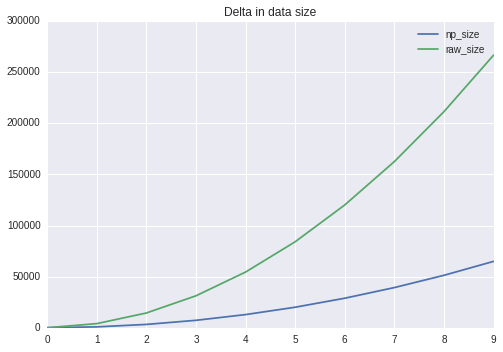

In [15]:
sizes = []
for i in range(0, 100, 10):
    arr = np.ones((i,i))
    sizes.append({
        'raw_size' : total_size(arr.tolist()),
        'np_size' : total_size(arr)
        })

pd.DataFrame(sizes).plot(title="Delta in data size")

## Code optimization

A few cool tricks that you can do with numpy / numba.

* Numpy - ufunc, gdfunc
* Numba - jit


# numpy optimizations

![language](https://snag.gy/9Bip8G.jpg)

* Many optimization librarys underneath - e.g. uses BLAS (http://www.netlib.org/blas/) or Intel Math Kernel Library (https://software.intel.com/en-us/intel-mkl)
* Special `ufunc`, `gufunc` that apply fast array operations
* Have interface with `pyCUDA` - Nvidia‘s CUDA parallel computation API 

## Example
    
    Fast fourier transform

https://jakevdp.github.io/blog/2015/02/24/optimizing-python-with-numpy-and-numba/

In [18]:
# Install nufft from http://github.com/dfm/python-nufft/
from nufft import nufft1 as nufft_fortran

from time import time

import numpy as np

def nufftfreqs(M, df=1):
    """Compute the frequency range used in nufft for M frequency bins"""
    return df * np.arange(-(M // 2), M - (M // 2))


def nudft(x, y, M, df=1.0, iflag=1):
    """Non-Uniform Direct Fourier Transform"""
    sign = -1 if iflag < 0 else 1
    return (1 / len(x)) * np.dot(y, np.exp(sign * 1j * nufftfreqs(M, df) * x[:, np.newaxis]))

def _compute_grid_params(M, eps):
    # Choose Msp & tau from eps following Dutt & Rokhlin (1993)
    if eps <= 1E-33 or eps >= 1E-1:
        raise ValueError("eps = {0:.0e}; must satisfy "
                         "1e-33 < eps < 1e-1.".format(eps))
    ratio = 2 if eps > 1E-11 else 3
    Msp = int(-np.log(eps) / (np.pi * (ratio - 1) / (ratio - 0.5)) + 0.5)
    Mr = max(ratio * M, 2 * Msp)
    lambda_ = Msp / (ratio * (ratio - 0.5))
    tau = np.pi * lambda_ / M ** 2
    return Msp, Mr, tau

def test_nufft(nufft_func, M=1000, Mtime=100000):
    # Test vs the direct method
    print(30 * '-')
    name = {'nufft1':'nufft_fortran'}.get(nufft_func.__name__,
                                          nufft_func.__name__)
    print("testing {0}".format(name))
    rng = np.random.RandomState(0)
    x = 100 * rng.rand(M + 1)
    y = np.sin(x)
    for df in [1, 2.0]:
        for iflag in [1, -1]:
            F1 = nudft(x, y, M, df=df, iflag=iflag)
            F2 = nufft_func(x, y, M, df=df, iflag=iflag)
            assert np.allclose(F1, F2)
    print("- Results match the DFT")
    
    # Time the nufft function
    x = 100 * rng.rand(Mtime)
    y = np.sin(x)
    times = []
    for i in range(5):
        t0 = time()
        F = nufft_func(x, y, Mtime)
        t1 = time()
        times.append(t1 - t0)
    print("- Execution time (M={0}): {1:.2g} sec".format(Mtime, np.median(times)))
 

In [19]:

def nufft_python(x, c, M, df=1.0, eps=1E-15, iflag=1):
    """Fast Non-Uniform Fourier Transform with Python"""
    Msp, Mr, tau = _compute_grid_params(M, eps)
    N = len(x)

    # Construct the convolved grid
    ftau = np.zeros(Mr, dtype=c.dtype)
    Mr = ftau.shape[0]
    hx = 2 * np.pi / Mr
    mm = np.arange(-Msp, Msp)
    for i in range(N):
        xi = (x[i] * df) % (2 * np.pi)
        m = 1 + int(xi // hx)
        spread = np.exp(-0.25 * (xi - hx * (m + mm)) ** 2 / tau)
        ftau[(m + mm) % Mr] += c[i] * spread

    # Compute the FFT on the convolved grid
    if iflag < 0:
        Ftau = (1 / Mr) * np.fft.fft(ftau)
    else:
        Ftau = np.fft.ifft(ftau)
    Ftau = np.concatenate([Ftau[-(M//2):], Ftau[:M//2 + M % 2]])

    # Deconvolve the grid using convolution theorem
    k = nufftfreqs(M)
    return (1 / N) * np.sqrt(np.pi / tau) * np.exp(tau * k ** 2) * Ftau
 

In [20]:
test_nufft(nufft_python)
test_nufft(nufft_fortran)

------------------------------
testing nufft_python
- Results match the DFT
- Execution time (M=100000): 1.3 sec
------------------------------
testing nufft_fortran
- Results match the DFT
- Execution time (M=100000): 0.043 sec


## numba.jit

Another very powerful library to be used.

* Compile python into llvm - which then compile into native code

In [109]:
from numba import jit

@numba.jit(nopython=True)
def build_grid_fast(x, c, tau, Msp, ftau, E3):
    Mr = ftau.shape[0]
    hx = 2 * np.pi / Mr
    
    # precompute some exponents
    for j in range(Msp + 1):
        E3[j] = np.exp(-(np.pi * j / Mr) ** 2 / tau)
        
    # spread values onto ftau
    for i in range(x.shape[0]):
        xi = x[i] % (2 * np.pi)
        m = 1 + int(xi // hx)
        xi = (xi - hx * m)
        E1 = np.exp(-0.25 * xi ** 2 / tau)
        E2 = np.exp((xi * np.pi) / (Mr * tau))
        E2mm = 1
        for mm in range(Msp):
            ftau[(m + mm) % Mr] += c[i] * E1 * E2mm * E3[mm]
            E2mm *= E2
            ftau[(m - mm - 1) % Mr] += c[i] * E1 / E2mm * E3[mm + 1]
    return ftau


def nufft_numba_fast(x, c, M, df=1.0, eps=1E-15, iflag=1):
    """Fast Non-Uniform Fourier Transform with Numba"""
    Msp, Mr, tau = _compute_grid_params(M, eps)
    N = len(x)

    # Construct the convolved grid
    ftau = build_grid_fast(x * df, c, tau, Msp,
                           np.zeros(Mr, dtype=c.dtype),
                           np.zeros(Msp + 1, dtype=x.dtype))

    # Compute the FFT on the convolved grid
    if iflag < 0:
        Ftau = (1 / Mr) * np.fft.fft(ftau)
    else:
        Ftau = np.fft.ifft(ftau)
    Ftau = np.concatenate([Ftau[-(M//2):], Ftau[:M//2 + M % 2]])

    # Deconvolve the grid using convolution theorem
    k = nufftfreqs(M)
    return (1 / N) * np.sqrt(np.pi / tau) * np.exp(tau * k ** 2) * Ftau

In [65]:
test_nufft(nufft_numba_fast)
test_nufft(nufft_fortran)

------------------------------
testing nufft_numba_fast
- Results match the DFT
- Execution time (M=100000): 0.063 sec
------------------------------
testing nufft_fortran
- Results match the DFT
- Execution time (M=100000): 0.042 sec


## What does the native code looks like

In [72]:
from numba.pycc import CC

cc = CC('fft')
# Uncomment the following line to print out the compilation steps
#cc.verbose = True

@cc.export('add_int', 'i8[:](i8[:])')
def add_int(x):
    return x + 0xcafebabe


@cc.export('build_grid_fast', 'f8[:](f8[:], f8[:], f8, i8, f8[:], f8[:])')
def build_grid_fast(x, c, tau, Msp, ftau, E3):
    Mr = ftau.shape[0]
    hx = 2 * np.pi / Mr
    
    # precompute some exponents
    for j in range(Msp + 1):
        E3[j] = np.exp(-(np.pi * j / Mr) ** 2 / tau)
        
    # spread values onto ftau
    for i in range(x.shape[0]):
        xi = x[i] % (2 * np.pi)
        m = 1 + int(xi // hx)
        xi = (xi - hx * m)
        E1 = np.exp(-0.25 * xi ** 2 / tau)
        E2 = np.exp((xi * np.pi) / (Mr * tau))
        E2mm = 1
        for mm in range(Msp):
            ftau[(m + mm) % Mr] += c[i] * E1 * E2mm * E3[mm]
            E2mm *= E2
            ftau[(m - mm - 1) % Mr] += c[i] * E1 / E2mm * E3[mm + 1]
    return ftau

cc.compile() 

In [55]:
!objdump -D fft.so > fft.dasm

In [101]:
!grep -B100 -A100 cafebabe fft.dasm

    3f10:	b8 01 00 00 00       	mov    $0x1,%eax
    3f15:	f0 48 0f c1 07       	lock xadd %rax,(%rdi)
    3f1a:	48 ff c0             	inc    %rax
    3f1d:	c3                   	retq   
    3f1e:	66 90                	xchg   %ax,%ax

0000000000003f20 <nrt_atomic_sub>:
    3f20:	48 c7 c0 ff ff ff ff 	mov    $0xffffffffffffffff,%rax
    3f27:	f0 48 0f c1 07       	lock xadd %rax,(%rdi)
    3f2c:	48 ff c8             	dec    %rax
    3f2f:	c3                   	retq   

0000000000003f30 <nrt_atomic_cas>:
    3f30:	48 89 f0             	mov    %rsi,%rax
    3f33:	f0 48 0f b1 17       	lock cmpxchg %rdx,(%rdi)
    3f38:	0f 94 c2             	sete   %dl
    3f3b:	48 89 01             	mov    %rax,(%rcx)
    3f3e:	0f b6 c2             	movzbl %dl,%eax
    3f41:	c3                   	retq   
    3f42:	66 66 66 66 66 2e 0f 	data16 data16 data16 data16 nopw %cs:0x0(%rax,%rax,1)
    3f49:	1f 84 00 00 00 00 00 

0000000000003f50 <NRT_MemInfo_data_fast>:
    3f50:	48 8b 47 18          	mov    0x18

The core `add_int` become just a 22 bytes loop (whole function size = 496 bytes)

```
    4050:	49 89 c6             	mov    %rax,%r14
    4053:	4d 8b 6e 18          	mov    0x18(%r14),%r13
    4057:	4d 85 e4             	test   %r12,%r12
    405a:	7e 47                	jle    40a3 <._pycc_method_add_int+0x113>
    405c:	b8 be ba fe ca       	mov    $0xcafebabe,%eax
    4061:	4c 89 e9             	mov    %r13,%rcx
    4064:	4c 89 e2             	mov    %r12,%rdx
    4067:	49 83 fc 02          	cmp    $0x2,%r12
    406b:	72 23                	jb     4090 <._pycc_method_add_int+0x100>
    406d:	0f 1f 00             	nopl   (%rax)
    4070:	48 8b 75 00          	mov    0x0(%rbp),%rsi
    4074:	48 01 c6             	add    %rax,%rsi
    4077:	48 89 31             	mov    %rsi,(%rcx)
    407a:	4c 01 fd             	add    %r15,%rbp
    407d:	48 83 c1 08          	add    $0x8,%rcx
    4081:	48 ff ca             	dec    %rdx
    4084:	75 ea                	jne    4070 <._pycc_method_add_int+0xe0>
    4086:	eb 1b                	jmp    40a3 <._pycc_method_add_int+0x113>
 ```

In [102]:
print("add_int Loop size: {}".format(0x4084+2-0x4070))
print("add_int Function size: {}".format(0x4180-0x3f90))

add_int Loop size: 22
add_int Function size: 496


In [107]:
!grep -A200 00004180.*_pycc_method_build_grid_fast  fft.dasm

0000000000004180 <._pycc_method_build_grid_fast>:
    4180:	55                   	push   %rbp
    4181:	41 57                	push   %r15
    4183:	41 56                	push   %r14
    4185:	41 55                	push   %r13
    4187:	41 54                	push   %r12
    4189:	53                   	push   %rbx
    418a:	48 81 ec 58 02 00 00 	sub    $0x258,%rsp
    4191:	48 89 fb             	mov    %rdi,%rbx
    4194:	48 8d 84 24 28 02 00 	lea    0x228(%rsp),%rax
    419b:	00 
    419c:	48 89 44 24 18       	mov    %rax,0x18(%rsp)
    41a1:	48 8d 84 24 30 02 00 	lea    0x230(%rsp),%rax
    41a8:	00 
    41a9:	48 89 44 24 10       	mov    %rax,0x10(%rsp)
    41ae:	48 8d 84 24 38 02 00 	lea    0x238(%rsp),%rax
    41b5:	00 
    41b6:	48 89 44 24 08       	mov    %rax,0x8(%rsp)
    41bb:	48 8d 84 24 40 02 00 	lea    0x240(%rsp),%rax
    41c2:	00 
    41c3:	48 89 04 24          	mov    %rax,(%rsp)
    41c7:	48 8d 2d 4f 8e 00 00 	lea    0x8e4f(%rip),%rbp        # d01d <.const.build_grid_f

The `_pycc_method_build_grid_fast` function - 2752 bytes

```
0000000000004180 <._pycc_method_build_grid_fast>:
    4180:	55                   	push   %rbp
    4181:	41 57                	push   %r15
    4183:	41 56                	push   %r14
    4185:	41 55                	push   %r13
    4187:	41 54                	push   %r12
    4189:	53                   	push   %rbx
    418a:	48 81 ec 58 02 00 00 	sub    $0x258,%rsp
    4191:	48 89 fb             	mov    %rdi,%rbx
    4194:	48 8d 84 24 28 02 00 	lea    0x228(%rsp),%rax
    419b:	00 
    419c:	48 89 44 24 18       	mov    %rax,0x18(%rsp)
    41a1:	48 8d 84 24 30 02 00 	lea    0x230(%rsp),%rax
    41a8:	00 
    41a9:	48 89 44 24 10       	mov    %rax,0x10(%rsp)
    41ae:	48 8d 84 24 38 02 00 	lea    0x238(%rsp),%rax
    41b5:	00 
    41b6:	48 89 44 24 08       	mov    %rax,0x8(%rsp)
    41bb:	48 8d 84 24 40 02 00 	lea    0x240(%rsp),%rax
    41c2:	00 
    41c3:	48 89 04 24          	mov    %rax,(%rsp)
    41c7:	48 8d 2d 4f 8e 00 00 	lea    0x8e4f(%rip),%rbp        # d01d <.const.build_grid_fast>
    41ce:	4c 8d 84 24 50 02 00 	lea    0x250(%rsp),%r8
    41d5:	00 
    41d6:	4c 8d 8c 24 48 02 00 	lea    0x248(%rsp),%r9
    41dd:	00 
    41de:	ba 06 00 00 00       	mov    $0x6,%edx
    41e3:	b9 06 00 00 00       	mov    $0x6,%ecx
    41e8:	31 c0                	xor    %eax,%eax
    41ea:	48 89 f7             	mov    %rsi,%rdi
    41ed:	48 89 ee             	mov    %rbp,%rsi
    41f0:	e8 fb f7 ff ff       	callq  39f0 <PyArg_UnpackTuple@plt>
    41f5:	66 0f 57 c0          	xorpd  %xmm0,%xmm0
    41f9:	66 0f 29 84 24 10 02 	movapd %xmm0,0x210(%rsp)
    4200:	00 00 
    4202:	66 0f 29 84 24 00 02 	movapd %xmm0,0x200(%rsp)
    4209:	00 00 
    420b:	66 0f 29 84 24 f0 01 	movapd %xmm0,0x1f0(%rsp)
    4212:	00 00 
    4214:	48 c7 84 24 20 02 00 	movq   $0x0,0x220(%rsp)
    421b:	00 00 00 00 00 
    4220:	66 0f 29 84 24 d0 01 	movapd %xmm0,0x1d0(%rsp) 
 ```

In [90]:
0x4c40-0x4180

2752

## Pattern: Scale up before your scale out

* Start with scaling up, prototype locally - easiest
* There're a lot of glue layer utilizing best of both world
  - pyspark, hadoop streaming
* In future: Worth checking out the Blaze ecosystem

## Summary: PyData can help!

* Build a good platform, let people play.
  - Open to other language - jupyter scala / zepplin

* Python can achieve pretty decent speed if you want to be careful
   * Writing it in C is faster - not really


# Thanks

Questions?

Come grab me anytime!